In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import re
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from gensim import corpora
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel
import gensim.downloader as api
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
import shap

In [21]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/eosamau/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/eosamau/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [22]:
train_data = pd.read_csv('drugsComTrain_raw.tsv', sep='\t')
test_data = pd.read_csv('drugsComTest_raw.tsv', sep='\t')
train_data.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


In [23]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    ps = PorterStemmer()
    tokens = [ps.stem(word) for word in tokens]
    return ' '.join(tokens)

train_data['processed_review'] = train_data['review'].apply(preprocess_text)
test_data['processed_review'] = test_data['review'].apply(preprocess_text)
train_data.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount,processed_review
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27,side effect take combin bystol mg fish oil
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192,son halfway fourth week intuniv becam concern ...
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17,use take anoth oral contracept pill cycl happi...
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10,first time use form birth control im glad went...
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37,suboxon complet turn life around feel healthie...


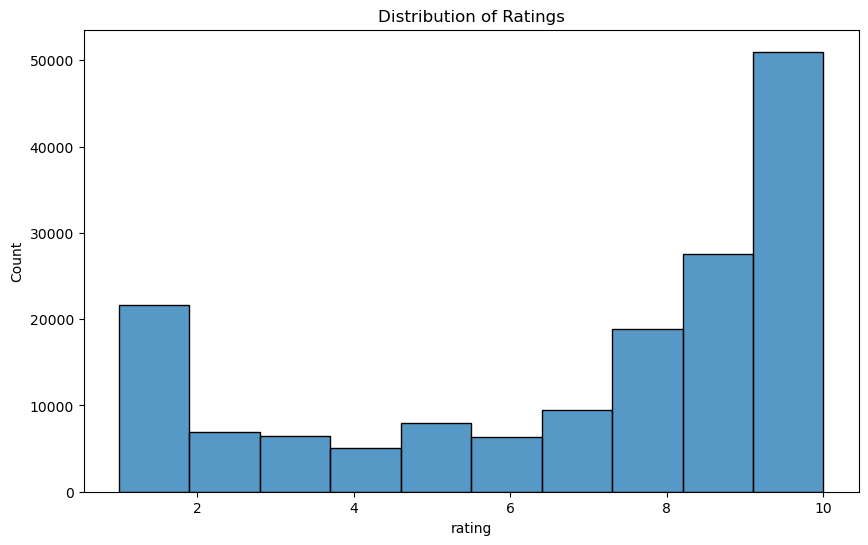

In [24]:
plt.figure(figsize=(10, 6))
sns.histplot(train_data['rating'], bins=10)
plt.title('Distribution of Ratings')
plt.savefig('rating_distribution.png')
plt.show()

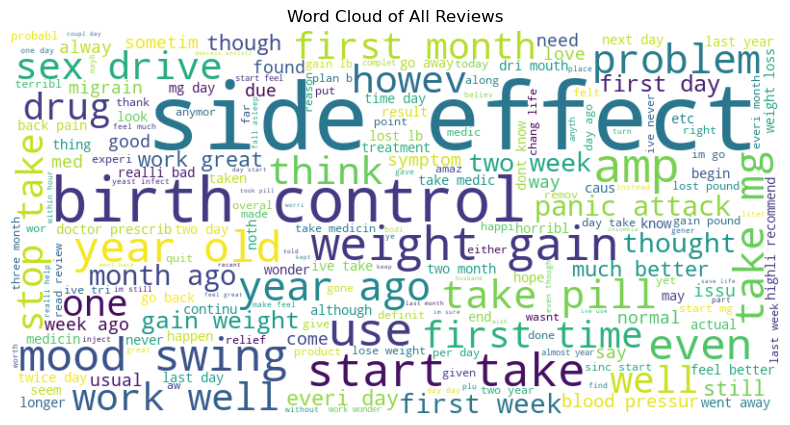

In [25]:
all_words = ' '.join(train_data['processed_review'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of All Reviews')
plt.savefig('wordcloud.png')
plt.show()

In [26]:
# TF-IDF
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(train_data['processed_review'])
y = train_data['rating']

# GloVe embeddings
glove_vectors = api.load("glove-wiki-gigaword-100")
max_length = 100

In [27]:
def text_to_sequence(texts):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    return pad_sequences(sequences, maxlen=max_length)

X_glove = text_to_sequence(train_data['processed_review'])

In [28]:
# Split data
X_train_tfidf, X_val_tfidf, y_train, y_val = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)
X_train_glove, X_val_glove, _, _ = train_test_split(X_glove, y, test_size=0.2, random_state=42)

In [29]:
# Naive Bayes
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)

# Logistic Regression
lr = LogisticRegression(random_state=42)
lr.fit(X_train_tfidf, y_train)

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_tfidf, y_train)

# LSTM with GloVe embeddings
vocab_size = len(glove_vectors.key_to_index)
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in glove_vectors.key_to_index.items():
    embedding_vector = glove_vectors.get_vector(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

model = Sequential([
    Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_length, trainable=False),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train_glove, y_train, epochs=5, batch_size=32, validation_split=0.1, verbose=1)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
3630/3630 ━━━━━━━━━━━━━━━━━━━━ 229s 63ms/step - accuracy: 0.1346 - loss: -791.7482 - val_accuracy: 0.1348 - val_loss: -2876.1401
Epoch 2/5
3630/3630 ━━━━━━━━━━━━━━━━━━━━ 227s 62ms/step - accuracy: 0.1360 - loss: -3593.1802 - val_accuracy: 0.1348 - val_loss: -5654.3560
Epoch 3/5
3630/3630 ━━━━━━━━━━━━━━━━━━━━ 473s 130ms/step - accuracy: 0.1351 - loss: -6378.5024 - val_accuracy: 0.1348 - val_loss: -8433.3750
Epoch 4/5
3630/3630 ━━━━━━━━━━━━━━━━━━━━ 3819s 1s/step - accuracy: 0.1330 - loss: -9210.7129 - val_accuracy: 0.1348 - val_loss: -11208.9600
Epoch 5/5
3630/3630 ━━━━━━━━━━━━━━━━━━━━ 614s 169ms/step - accuracy: 0.1330 - loss: -12027.6191 - val_accuracy: 0.1348 - val_loss: -13984.8086


#### Model Evaluation


Naive Bayes Performance:
Accuracy: 0.3886
Classification Report:
              precision    recall  f1-score   support

         1.0       0.47      0.52      0.49      4273
         2.0       0.00      0.00      0.00      1375
         3.0       0.33      0.00      0.01      1343
         4.0       1.00      0.00      0.00       970
         5.0       0.32      0.00      0.01      1623
         6.0       0.00      0.00      0.00      1331
         7.0       0.00      0.00      0.00      1945
         8.0       0.27      0.02      0.04      3754
         9.0       0.23      0.08      0.12      5408
        10.0       0.39      0.95      0.55     10238

    accuracy                           0.39     32260
   macro avg       0.30      0.16      0.12     32260
weighted avg       0.32      0.39      0.27     32260



/var/folders/k7/4jxrys1x095bqc5bhnsrf1n00000gn/T/ipykernel_41175/992620980.py:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('Set1')(np.linspace(0, 1, n_classes))


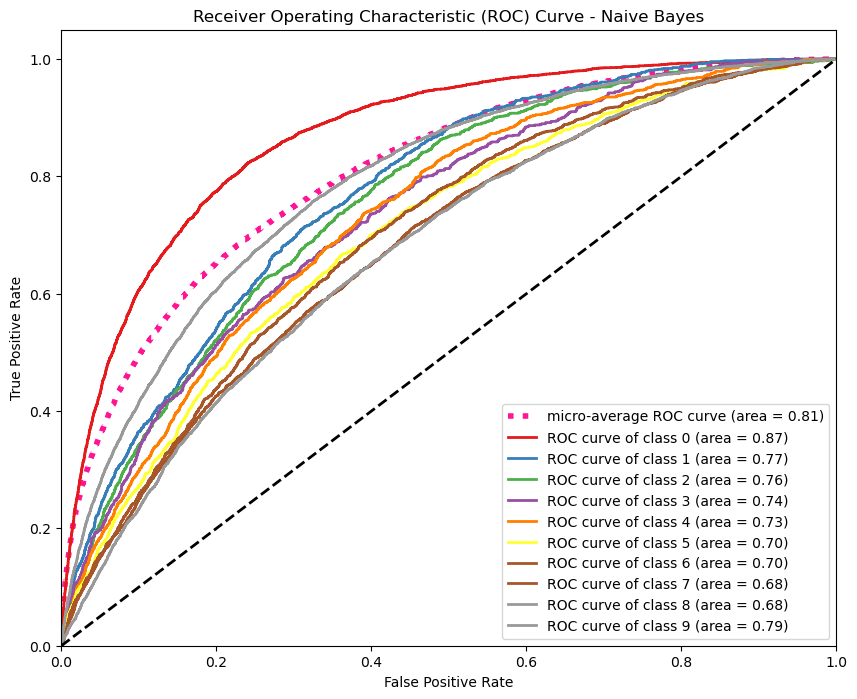

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite


Logistic Regression Performance:
Accuracy: 0.4325
Classification Report:
              precision    recall  f1-score   support

         1.0       0.47      0.73      0.58      4273
         2.0       0.27      0.03      0.06      1375
         3.0       0.24      0.04      0.07      1343
         4.0       0.24      0.02      0.04       970
         5.0       0.22      0.07      0.11      1623
         6.0       0.31      0.03      0.05      1331
         7.0       0.22      0.05      0.08      1945
         8.0       0.25      0.18      0.21      3754
         9.0       0.28      0.22      0.25      5408
        10.0       0.50      0.84      0.63     10238

    accuracy                           0.43     32260
   macro avg       0.30      0.22      0.21     32260
weighted avg       0.36      0.43      0.36     32260



/var/folders/k7/4jxrys1x095bqc5bhnsrf1n00000gn/T/ipykernel_41175/992620980.py:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('Set1')(np.linspace(0, 1, n_classes))


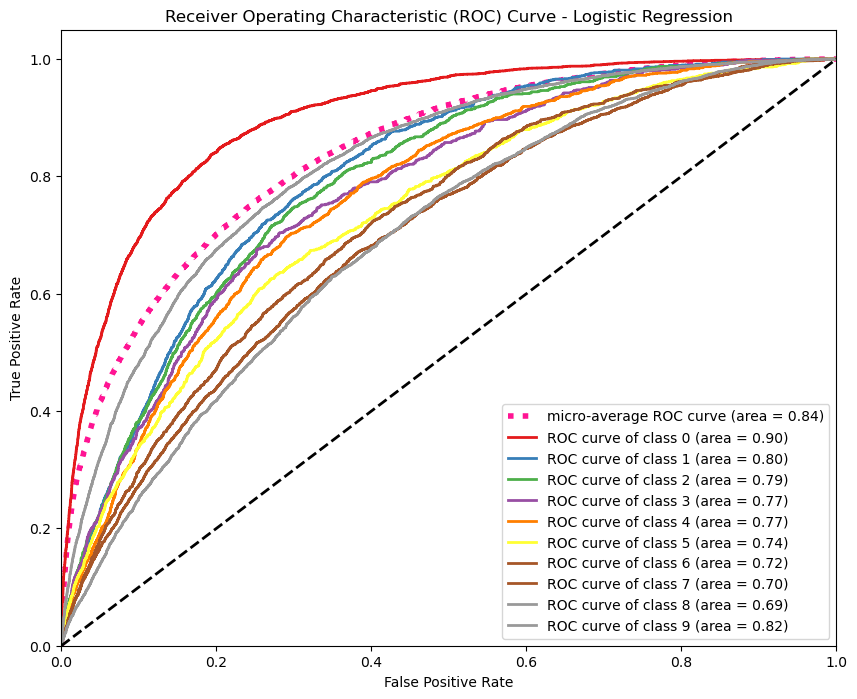


Random Forest Performance:
Accuracy: 0.6782
Classification Report:
              precision    recall  f1-score   support

         1.0       0.72      0.76      0.74      4273
         2.0       0.90      0.49      0.64      1375
         3.0       0.92      0.50      0.65      1343
         4.0       0.88      0.47      0.61       970
         5.0       0.88      0.50      0.64      1623
         6.0       0.89      0.47      0.62      1331
         7.0       0.91      0.48      0.63      1945
         8.0       0.81      0.50      0.62      3754
         9.0       0.74      0.52      0.61      5408
        10.0       0.58      0.95      0.72     10238

    accuracy                           0.68     32260
   macro avg       0.82      0.57      0.65     32260
weighted avg       0.73      0.68      0.67     32260



/var/folders/k7/4jxrys1x095bqc5bhnsrf1n00000gn/T/ipykernel_41175/992620980.py:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('Set1')(np.linspace(0, 1, n_classes))


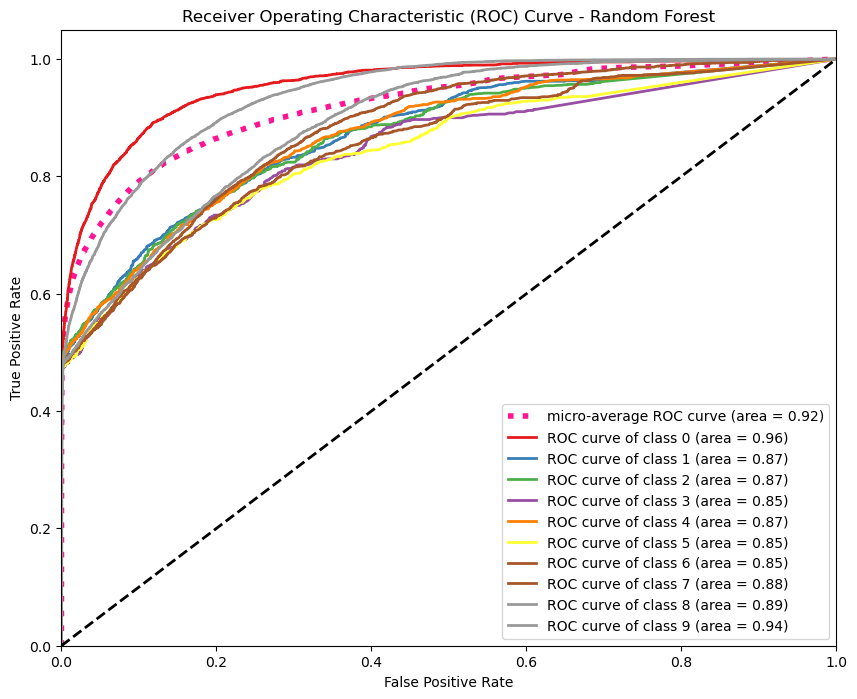

In [30]:
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

def evaluate_model(model, X_val, y_val, model_name):
    # For multi-class problems, we need to use OneVsRestClassifier
    if len(np.unique(y_val)) > 2:
        model = OneVsRestClassifier(model)
        model.fit(X_train_tfidf, y_train)
    
    y_pred = model.predict(X_val)
    y_pred_proba = model.predict_proba(X_val)
    
    print(f"\n{model_name} Performance:")
    print(f"Accuracy: {accuracy_score(y_val, y_pred):.4f}")
    print(f"Classification Report:\n{classification_report(y_val, y_pred)}")
    
    # Compute ROC curve and ROC area for each class
    n_classes = len(np.unique(y_val))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    # Binarize the output for multi-class ROC
    y_val_bin = label_binarize(y_val, classes=np.unique(y_val))
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_val_bin.ravel(), y_pred_proba.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot ROC curve
    plt.figure(figsize=(10, 8))
    plt.plot(fpr["micro"], tpr["micro"],
             label=f'micro-average ROC curve (area = {roc_auc["micro"]:.2f})',
             color='deeppink', linestyle=':', linewidth=4)
    
    colors = plt.cm.get_cmap('Set1')(np.linspace(0, 1, n_classes))
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.savefig(f'roc_curve_{model_name.replace(" ", "_").lower()}.png')
    plt.show()

# Evaluate models
evaluate_model(nb, X_val_tfidf, y_val, "Naive Bayes")
evaluate_model(lr, X_val_tfidf, y_val, "Logistic Regression")
evaluate_model(rf, X_val_tfidf, y_val, "Random Forest")
